# Week 2 - Notebook 2.2: ÊûÑÂª∫‰∏âËá™Áî±Â∫¶Êú∫Ê¢∞ËáÇ / Building a 3-DOF Robotic Arm

## Â≠¶‰π†ÁõÆÊ†á / Learning Objectives
- ËÆæËÆ°ËøêÂä®Â≠¶Èìæ / Design kinematic chain
- Ê∑ªÂä†Âá†‰ΩïÂΩ¢Áä∂ÂíåÁ¢∞Êíû‰Ωì / Add geometries and collision bodies
- ÈÖçÁΩÆÂÖ≥ËäÇÈôê‰ΩçÂíåÈòªÂ∞º / Configure joint limits and damping
- Ê∑ªÂä†ÊâßË°åÂô®Âíå‰º†Âä® / Add actuators and transmissions
- ÂÆûÁé∞Âü∫Á°ÄÊéßÂà∂ / Implement basic control

---

## 1. ÁéØÂ¢ÉÂáÜÂ§á / Environment Setup

In [23]:
# ÂØºÂÖ•ÂøÖË¶ÅÁöÑÂ∫ì / Import necessary libraries
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mediapy as media
from typing import List, Tuple, Optional, Dict
import time
from IPython.display import HTML

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê / Set random seed
np.random.seed(42)

print(f"MuJoCo version: {mujoco.__version__}")

MuJoCo version: 3.3.4


## 2. Êú∫Ê¢∞ËáÇËÆæËÆ°ÂéüÁêÜ / Robotic Arm Design Principles

### DHÂèÇÊï∞ (Denavit-Hartenberg Parameters)
Êú∫Ê¢∞ËáÇÁöÑËøêÂä®Â≠¶ÈÄöÂ∏∏Áî®DHÂèÇÊï∞ÊèèËø∞ / Robot kinematics are often described using DH parameters

ÂØπ‰∫éÊàë‰ª¨ÁöÑ3-DOFÊú∫Ê¢∞ËáÇ / For our 3-DOF arm:
- **ÂÖ≥ËäÇ1**: Âü∫Â∫ßÊóãËΩ¨ (Yaw) / Base rotation
- **ÂÖ≥ËäÇ2**: ËÇ©ÈÉ®‰øØ‰ª∞ (Pitch) / Shoulder pitch
- **ÂÖ≥ËäÇ3**: ËÇòÈÉ®‰øØ‰ª∞ (Pitch) / Elbow pitch

In [24]:
# ÂÆö‰πâÊú∫Ê¢∞ËáÇÂèÇÊï∞ / Define arm parameters
class ArmParameters:
    """Êú∫Ê¢∞ËáÇÂèÇÊï∞Á±ª / Arm parameters class"""
    def __init__(self):
        # ÈìæÊé•ÈïøÂ∫¶ / Link lengths
        self.base_height = 0.1
        self.link1_length = 0.3  # ‰∏äËáÇ / Upper arm
        self.link2_length = 0.25  # ÂâçËáÇ / Forearm
        
        # ÈìæÊé•ÂçäÂæÑ / Link radii
        self.base_radius = 0.05
        self.link_radius = 0.03
        
        # ÂÖ≥ËäÇÈôê‰Ωç (Â∫¶) / Joint limits (degrees)
        self.joint_limits = [
            (-180, 180),  # Âü∫Â∫ßÊóãËΩ¨ / Base rotation
            (-90, 90),    # ËÇ©ÈÉ®‰øØ‰ª∞ / Shoulder pitch
            (-135, 135)   # ËÇòÈÉ®‰øØ‰ª∞ / Elbow pitch
        ]
        
        # È¢úËâ≤ / Colors
        self.base_color = [0.2, 0.2, 0.2, 1]     # Ê∑±ÁÅ∞ / Dark gray
        self.link1_color = [0.8, 0.2, 0.2, 1]    # Á∫¢Ëâ≤ / Red
        self.link2_color = [0.2, 0.2, 0.8, 1]    # ËìùËâ≤ / Blue
        self.joint_color = [0.7, 0.7, 0.7, 1]    # ÊµÖÁÅ∞ / Light gray

params = ArmParameters()
print(f"Êú∫Ê¢∞ËáÇÊÄªÈïøÂ∫¶ / Total arm length: {params.link1_length + params.link2_length:.2f}m")

Êú∫Ê¢∞ËáÇÊÄªÈïøÂ∫¶ / Total arm length: 0.55m


## 3. ÂàõÂª∫Êú∫Ê¢∞ËáÇXMLÊ®°Âûã / Create Robotic Arm XML Model

In [25]:
def create_3dof_arm_xml(params: ArmParameters) -> str:
    """
    ÂàõÂª∫3Ëá™Áî±Â∫¶Êú∫Ê¢∞ËáÇÁöÑMJCF XML / Create MJCF XML for 3-DOF arm
    """
    xml = f"""
    <mujoco model="3dof_robotic_arm">
        <!-- ‰ªøÁúüÂèÇÊï∞ / Simulation parameters -->
        <option timestep="0.001" gravity="0 0 -9.81" integrator="RK4"/>
        
        <!-- ÈªòËÆ§ËÆæÁΩÆ / Default settings -->
        <default>
            <joint armature="0.01" damping="0.1"/>
            <geom contype="1" conaffinity="1" friction="1 0.1 0.1" solref="0.02 1"/>
            <motor ctrllimited="true" ctrlrange="-1 1"/>
        </default>
        
        <!-- ËµÑÊ∫ê / Assets -->
        <asset>
            <material name="floor_mat" specular="0.3" shininess="0.1" rgba="0.8 0.8 0.8 1"/>
            <material name="base_mat" rgba="{' '.join(map(str, params.base_color))}"/>
            <material name="link1_mat" rgba="{' '.join(map(str, params.link1_color))}"/>
            <material name="link2_mat" rgba="{' '.join(map(str, params.link2_color))}"/>
            <material name="joint_mat" rgba="{' '.join(map(str, params.joint_color))}"/>
        </asset>
        
        <!-- ‰∏ñÁïå / World -->
        <worldbody>
            <!-- ÂÖâÊ∫ê / Lights -->
            <light name="light1" pos="2 2 2" dir="-1 -1 -1" diffuse="1 1 1"/>
            <light name="light2" pos="-2 2 2" dir="1 -1 -1" diffuse="0.5 0.5 0.5"/>
            
            <!-- Âú∞Èù¢ / Ground -->
            <geom name="floor" type="plane" size="2 2 0.1" material="floor_mat"/>
            
            <!-- Â∑•‰ΩúÂè∞ / Workbench -->
            <body name="table" pos="0 0 0.4">
                <geom name="tabletop" type="box" size="0.6 0.4 0.02" rgba="0.6 0.4 0.2 1"/>
            </body>
            
            <!-- Êú∫Ê¢∞ËáÇÂü∫Â∫ß / Arm base -->
            <body name="base" pos="0 0 0.42">
                <geom name="base_geom" type="cylinder" size="{params.base_radius} {params.base_height}" material="base_mat"/>
                
                <!-- ÂÖ≥ËäÇ1: Âü∫Â∫ßÊóãËΩ¨ / Joint 1: Base rotation -->
                <body name="link1" pos="0 0 {params.base_height}">
                    <joint name="joint1" type="hinge" axis="0 0 1" 
                           range="{params.joint_limits[0][0]} {params.joint_limits[0][1]}"/>
                    <geom name="joint1_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat"/>
                    
                    <!-- ‰∏äËáÇ / Upper arm -->
                    <geom name="link1_geom" type="capsule" 
                          fromto="0 0 0.02 0 0 {params.link1_length}" 
                          size="{params.link_radius}" material="link1_mat"/>
                    
                    <!-- ÂÖ≥ËäÇ2: ËÇ©ÈÉ®‰øØ‰ª∞ / Joint 2: Shoulder pitch -->
                    <body name="link2" pos="0 0 {params.link1_length}">
                        <joint name="joint2" type="hinge" axis="0 1 0" 
                               range="{params.joint_limits[1][0]} {params.joint_limits[1][1]}"/>
                        <geom name="joint2_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat" euler="90 0 0"/>
                        
                        <!-- ÂâçËáÇ / Forearm -->
                        <geom name="link2_geom" type="capsule" 
                              fromto="0 0 0.02 0 0 {params.link2_length}" 
                              size="{params.link_radius}" material="link2_mat"/>
                        
                        <!-- ÂÖ≥ËäÇ3: ËÇòÈÉ®‰øØ‰ª∞ / Joint 3: Elbow pitch -->
                        <body name="link3" pos="0 0 {params.link2_length}">
                            <joint name="joint3" type="hinge" axis="0 1 0" 
                                   range="{params.joint_limits[2][0]} {params.joint_limits[2][1]}"/>
                            <geom name="joint3_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat" euler="90 0 0"/>
                            
                            <!-- Êú´Á´ØÊâßË°åÂô® / End effector -->
                            <body name="end_effector" pos="0 0 0.05">
                                <geom name="ee_geom" type="sphere" size="0.02" rgba="1 1 0 1"/>
                                <site name="ee_site" pos="0 0 0" size="0.01" rgba="1 0 0 1"/>
                            </body>
                        </body>
                    </body>
                </body>
            </body>
            
            <!-- ÁõÆÊ†áÊ†áËÆ∞ / Target marker -->
            <body name="target" pos="0.3 0.2 0.6">
                <geom name="target_geom" type="sphere" size="0.03" rgba="0 1 0 0.5" contype="0" conaffinity="0"/>
                <site name="target_site" pos="0 0 0" size="0.01" rgba="0 1 0 1"/>
            </body>
        </worldbody>
        
        <!-- ÊâßË°åÂô® / Actuators -->
        <actuator>
            <!-- ‰ΩçÁΩÆÊéßÂà∂Âô® / Position controllers -->
            <position name="joint1_pos" joint="joint1" kp="100" ctrlrange="{params.joint_limits[0][0]} {params.joint_limits[0][1]}"/>
            <position name="joint2_pos" joint="joint2" kp="100" ctrlrange="{params.joint_limits[1][0]} {params.joint_limits[1][1]}"/>
            <position name="joint3_pos" joint="joint3" kp="100" ctrlrange="{params.joint_limits[2][0]} {params.joint_limits[2][1]}"/>
            
            <!-- ÈÄüÂ∫¶ÊéßÂà∂Âô® (Â§áÈÄâ) / Velocity controllers (alternative) -->
            <velocity name="joint1_vel" joint="joint1" kv="10"/>
            <velocity name="joint2_vel" joint="joint2" kv="10"/>
            <velocity name="joint3_vel" joint="joint3" kv="10"/>
        </actuator>
        
        <!-- ‰º†ÊÑüÂô® / Sensors -->
        <sensor>
            <!-- ÂÖ≥ËäÇ‰ΩçÁΩÆ‰º†ÊÑüÂô® / Joint position sensors -->
            <jointpos name="joint1_pos_sensor" joint="joint1"/>
            <jointpos name="joint2_pos_sensor" joint="joint2"/>
            <jointpos name="joint3_pos_sensor" joint="joint3"/>
            
            <!-- ÂÖ≥ËäÇÈÄüÂ∫¶‰º†ÊÑüÂô® / Joint velocity sensors -->
            <jointvel name="joint1_vel_sensor" joint="joint1"/>
            <jointvel name="joint2_vel_sensor" joint="joint2"/>
            <jointvel name="joint3_vel_sensor" joint="joint3"/>
            
            <!-- Êú´Á´ØÊâßË°åÂô®‰ΩçÁΩÆ / End effector position -->
            <framepos name="ee_pos" objtype="site" objname="ee_site"/>
            
            <!-- ÁõÆÊ†áË∑ùÁ¶ª / Distance to target -->
            <rangefinder name="ee_target_dist" site="ee_site"/>
        </sensor>
    </mujoco>
    """
    return xml

# ÂàõÂª∫Ê®°Âûã / Create model
arm_xml = create_3dof_arm_xml(params)
arm_model = mujoco.MjModel.from_xml_string(arm_xml)
arm_data = mujoco.MjData(arm_model)

print(f"Ê®°ÂûãÂàõÂª∫ÊàêÂäü / Model created successfully!")
print(f"Ëá™Áî±Â∫¶ / DOF: {arm_model.nv}")
print(f"ÊéßÂà∂ËæìÂÖ• / Control inputs: {arm_model.nu}")
print(f"‰º†ÊÑüÂô®Êï∞Èáè / Number of sensors: {arm_model.nsensor}")

Ê®°ÂûãÂàõÂª∫ÊàêÂäü / Model created successfully!
Ëá™Áî±Â∫¶ / DOF: 3
ÊéßÂà∂ËæìÂÖ• / Control inputs: 6
‰º†ÊÑüÂô®Êï∞Èáè / Number of sensors: 8


## 4. ËøêÂä®Â≠¶ÂàÜÊûê / Kinematic Analysis

In [26]:
def forward_kinematics(q: np.ndarray, params: ArmParameters) -> np.ndarray:
    """
    ËÆ°ÁÆóÊ≠£ÂêëËøêÂä®Â≠¶ / Compute forward kinematics
    
    Args:
        q: ÂÖ≥ËäÇËßíÂ∫¶ [q1, q2, q3] (radians)
        params: Êú∫Ê¢∞ËáÇÂèÇÊï∞ / Arm parameters
    
    Returns:
        Êú´Á´ØÊâßË°åÂô®‰ΩçÁΩÆ [x, y, z]
    """
    q1, q2, q3 = q
    
    # Âü∫Â∫ßÈ´òÂ∫¶ / Base height
    z0 = 0.42 + params.base_height
    
    # ËÆ°ÁÆóÂêÑÂÖ≥ËäÇ‰ΩçÁΩÆ / Calculate joint positions
    # ÂÖ≥ËäÇ2‰ΩçÁΩÆ / Joint 2 position
    x2 = 0
    y2 = 0
    z2 = z0 + params.link1_length
    
    # Êú´Á´ØÊâßË°åÂô®‰ΩçÁΩÆ / End effector position
    # ËÄÉËôëÊâÄÊúâÊóãËΩ¨ / Consider all rotations
    l2 = params.link2_length + 0.05  # ÂåÖÊã¨Êú´Á´Ø / Including end
    
    x = l2 * np.cos(q1) * np.sin(q2 + q3)
    y = l2 * np.sin(q1) * np.sin(q2 + q3)
    z = z2 + l2 * np.cos(q2 + q3)
    
    return np.array([x, y, z])

def compute_jacobian(model: mujoco.MjModel, data: mujoco.MjData) -> np.ndarray:
    """
    ËÆ°ÁÆóÈõÖÂèØÊØîÁü©Èòµ / Compute Jacobian matrix
    """
    # Ëé∑ÂèñÊú´Á´ØÊâßË°åÂô®ÁöÑbody id
    # Fix: Use mj_name2id instead of model.body()
    ee_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'end_effector')
    
    # ÂàõÂª∫ÈõÖÂèØÊØîÁü©Èòµ / Create Jacobian matrices
    jacp = np.zeros((3, model.nv))  # ‰ΩçÁΩÆÈõÖÂèØÊØî / Position Jacobian
    jacr = np.zeros((3, model.nv))  # ÊóãËΩ¨ÈõÖÂèØÊØî / Rotation Jacobian
    
    # ËÆ°ÁÆóÈõÖÂèØÊØî / Compute Jacobian
    mujoco.mj_jacBody(model, data, jacp, jacr, ee_body_id)
    
    return jacp

# ÊµãËØïËøêÂä®Â≠¶ / Test kinematics
test_angles = np.array([0, np.pi/4, -np.pi/4])  # ÊµãËØïËßíÂ∫¶ / Test angles
ee_pos_fk = forward_kinematics(test_angles, params)

# ‰ΩøÁî®MuJoCoÈ™åËØÅ / Verify with MuJoCo
arm_data.qpos[:3] = test_angles
mujoco.mj_forward(arm_model, arm_data)
ee_pos_mj = arm_data.site('ee_site').xpos

print(f"Ê≠£ÂêëËøêÂä®Â≠¶ÁªìÊûú / Forward kinematics results:")
print(f"Ëá™ÂÆö‰πâËÆ°ÁÆó / Custom calculation: {ee_pos_fk}")
print(f"MuJoCoËÆ°ÁÆó / MuJoCo calculation: {ee_pos_mj}")
print(f"ËØØÂ∑Æ / Error: {np.linalg.norm(ee_pos_fk - ee_pos_mj):.6f}")

Ê≠£ÂêëËøêÂä®Â≠¶ÁªìÊûú / Forward kinematics results:
Ëá™ÂÆö‰πâËÆ°ÁÆó / Custom calculation: [0.   0.   1.12]
MuJoCoËÆ°ÁÆó / MuJoCo calculation: [0.1767767 0.        1.0467767]
ËØØÂ∑Æ / Error: 0.191342


## 5. Á¢∞ÊíûÊ£ÄÊµã‰∏éÂèØËßÜÂåñ / Collision Detection and Visualization

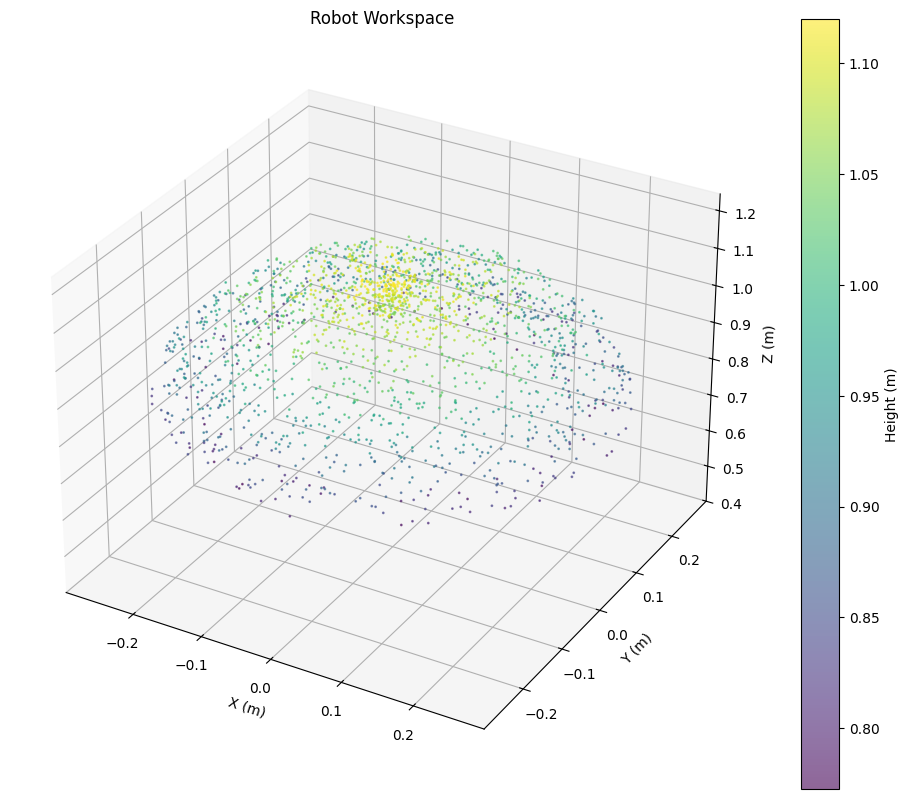

In [27]:
def visualize_workspace(model: mujoco.MjModel, params: ArmParameters, samples: int = 1000):
    """
    ÂèØËßÜÂåñÊú∫Ê¢∞ËáÇÂ∑•‰ΩúÁ©∫Èó¥ / Visualize robot workspace
    """
    data = mujoco.MjData(model)
    workspace_points = []
    
    # ÈöèÊú∫ÈááÊ†∑ÂÖ≥ËäÇËßíÂ∫¶ / Random sample joint angles
    for _ in range(samples):
        # Âú®ÂÖ≥ËäÇÈôê‰ΩçÂÜÖÈöèÊú∫ÈááÊ†∑ / Random sample within joint limits
        q = np.zeros(3)
        for i in range(3):
            q[i] = np.random.uniform(
                np.radians(params.joint_limits[i][0]),
                np.radians(params.joint_limits[i][1])
            )
        
        # ËÆæÁΩÆÂÖ≥ËäÇËßíÂ∫¶ / Set joint angles
        data.qpos[:3] = q
        mujoco.mj_forward(model, data)
        
        # Ëé∑ÂèñÊú´Á´Ø‰ΩçÁΩÆ / Get end effector position
        ee_pos = data.site('ee_site').xpos.copy()
        workspace_points.append(ee_pos)
    
    workspace_points = np.array(workspace_points)
    
    # 3DÂèØËßÜÂåñ / 3D visualization
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # ÁªòÂà∂Â∑•‰ΩúÁ©∫Èó¥ÁÇπ‰∫ë / Plot workspace point cloud
    scatter = ax.scatter(workspace_points[:, 0], 
                        workspace_points[:, 1], 
                        workspace_points[:, 2],
                        c=workspace_points[:, 2],  # ÊåâÈ´òÂ∫¶ÁùÄËâ≤ / Color by height
                        cmap='viridis', 
                        alpha=0.6,
                        s=1)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title("Robot Workspace")
    
    # Ê∑ªÂä†È¢úËâ≤Êù° / Add colorbar
    plt.colorbar(scatter, ax=ax, label='Height (m)')
    
    # ËÆæÁΩÆÁõ∏Á≠âÁöÑËΩ¥ÊØî‰æã / Set equal axis scales
    max_range = np.array([workspace_points[:, 0].max() - workspace_points[:, 0].min(),
                         workspace_points[:, 1].max() - workspace_points[:, 1].min(),
                         workspace_points[:, 2].max() - workspace_points[:, 2].min()]).max() / 2.0
    
    mid_x = (workspace_points[:, 0].max() + workspace_points[:, 0].min()) * 0.5
    mid_y = (workspace_points[:, 1].max() + workspace_points[:, 1].min()) * 0.5
    mid_z = (workspace_points[:, 2].max() + workspace_points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(0.4, mid_z + max_range)
    
    plt.show()
    
    return workspace_points

# ÂèØËßÜÂåñÂ∑•‰ΩúÁ©∫Èó¥ / Visualize workspace
workspace = visualize_workspace(arm_model, params, samples=2000)

## 6. ÊéßÂà∂Âô®ÂÆûÁé∞ / Controller Implementation

In [28]:
class RobotArmController:
    """
    Êú∫Ê¢∞ËáÇÊéßÂà∂Âô®Á±ª / Robot arm controller class
    """
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData):
        self.model = model
        self.data = data
        self.target_pos = np.array([0.3, 0.2, 0.6])  # ÈªòËÆ§ÁõÆÊ†á‰ΩçÁΩÆ / Default target position
        
        # PIDÂèÇÊï∞ / PID parameters
        self.kp = np.array([2.0, 2.0, 2.0])  # ÊØî‰æãÂ¢ûÁõä / Proportional gain
        self.ki = np.array([0.1, 0.1, 0.1])  # ÁßØÂàÜÂ¢ûÁõä / Integral gain
        self.kd = np.array([0.5, 0.5, 0.5])  # ÂæÆÂàÜÂ¢ûÁõä / Derivative gain
        
        self.error_integral = np.zeros(3)
        self.last_error = np.zeros(3)
        
    def inverse_kinematics_jacobian(self, target_pos: np.ndarray, max_iter: int = 100, tol: float = 1e-3):
        """
        ‰ΩøÁî®ÈõÖÂèØÊØîÊñπÊ≥ïÁöÑÈÄÜËøêÂä®Â≠¶ / Inverse kinematics using Jacobian method
        """
        for i in range(max_iter):
            # ÂΩìÂâçÊú´Á´Ø‰ΩçÁΩÆ / Current end effector position
            ee_pos = self.data.site('ee_site').xpos
            
            # ‰ΩçÁΩÆËØØÂ∑Æ / Position error
            error = target_pos - ee_pos
            
            # Ê£ÄÊü•ÊòØÂê¶Êî∂Êïõ / Check convergence
            if np.linalg.norm(error) < tol:
                return self.data.qpos[:3].copy()
            
            # ËÆ°ÁÆóÈõÖÂèØÊØî / Compute Jacobian
            J = compute_jacobian(self.model, self.data)
            
            # ËÆ°ÁÆó‰º™ÈÄÜ / Compute pseudo-inverse
            J_pinv = np.linalg.pinv(J)
            
            # ËÆ°ÁÆóÂÖ≥ËäÇÈÄüÂ∫¶ / Compute joint velocities
            dq = J_pinv @ error
            
            # Êõ¥Êñ∞ÂÖ≥ËäÇËßíÂ∫¶ / Update joint angles
            self.data.qpos[:3] += 0.1 * dq  # Ê≠•ÈïøÂõ†Â≠ê / Step size factor
            
            # Â∫îÁî®ÂÖ≥ËäÇÈôê‰Ωç / Apply joint limits
            for j in range(3):
                self.data.qpos[j] = np.clip(
                    self.data.qpos[j],
                    self.model.jnt_range[j, 0],
                    self.model.jnt_range[j, 1]
                )
            
            # Êõ¥Êñ∞‰ªøÁúü / Update simulation
            mujoco.mj_forward(self.model, self.data)
        
        print(f"Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge")
        return self.data.qpos[:3].copy()
    
    def pid_control(self, target_angles: np.ndarray, dt: float = 0.001):
        """
        PIDÊéßÂà∂Âô® / PID controller
        """
        # ÂΩìÂâçÂÖ≥ËäÇËßíÂ∫¶ / Current joint angles
        current_angles = self.data.qpos[:3]
        
        # ËÆ°ÁÆóËØØÂ∑Æ / Compute error
        error = target_angles - current_angles
        
        # PIDËÆ°ÁÆó / PID calculation
        self.error_integral += error * dt
        error_derivative = (error - self.last_error) / dt
        
        # ÊéßÂà∂ËæìÂá∫ / Control output
        control = (self.kp * error + 
                  self.ki * self.error_integral + 
                  self.kd * error_derivative)
        
        # Êõ¥Êñ∞ÂéÜÂè≤ËØØÂ∑Æ / Update error history
        self.last_error = error.copy()
        
        # Â∫îÁî®ÊéßÂà∂ / Apply control
        self.data.ctrl[:3] = control
        
        return control

# ÂàõÂª∫ÊéßÂà∂Âô® / Create controller
controller = RobotArmController(arm_model, arm_data)

# ÊµãËØïÈÄÜËøêÂä®Â≠¶ / Test inverse kinematics
target = np.array([0.3, 0.2, 0.6])
mujoco.mj_resetData(arm_model, arm_data)  # ÈáçÁΩÆÁä∂ÊÄÅ / Reset state
ik_solution = controller.inverse_kinematics_jacobian(target)

print(f"ÁõÆÊ†á‰ΩçÁΩÆ / Target position: {target}")
print(f"IKËß£ / IK solution (degrees): {np.degrees(ik_solution)}")
print(f"ÂÆûÈôÖÊú´Á´Ø‰ΩçÁΩÆ / Actual end position: {arm_data.site('ee_site').xpos}")
print(f"‰ΩçÁΩÆËØØÂ∑Æ / Position error: {np.linalg.norm(target - arm_data.site('ee_site').xpos):.4f}m")

Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge
ÁõÆÊ†á‰ΩçÁΩÆ / Target position: [0.3 0.2 0.6]
IKËß£ / IK solution (degrees): [ 33.69006488  90.         -22.72057292]
ÂÆûÈôÖÊú´Á´Ø‰ΩçÁΩÆ / Actual end position: [0.24638672 0.1642578  0.83931186]
‰ΩçÁΩÆËØØÂ∑Æ / Position error: 0.2478m


## 7. ËΩ®ËøπËßÑÂàí‰∏éÊâßË°å / Trajectory Planning and Execution

/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


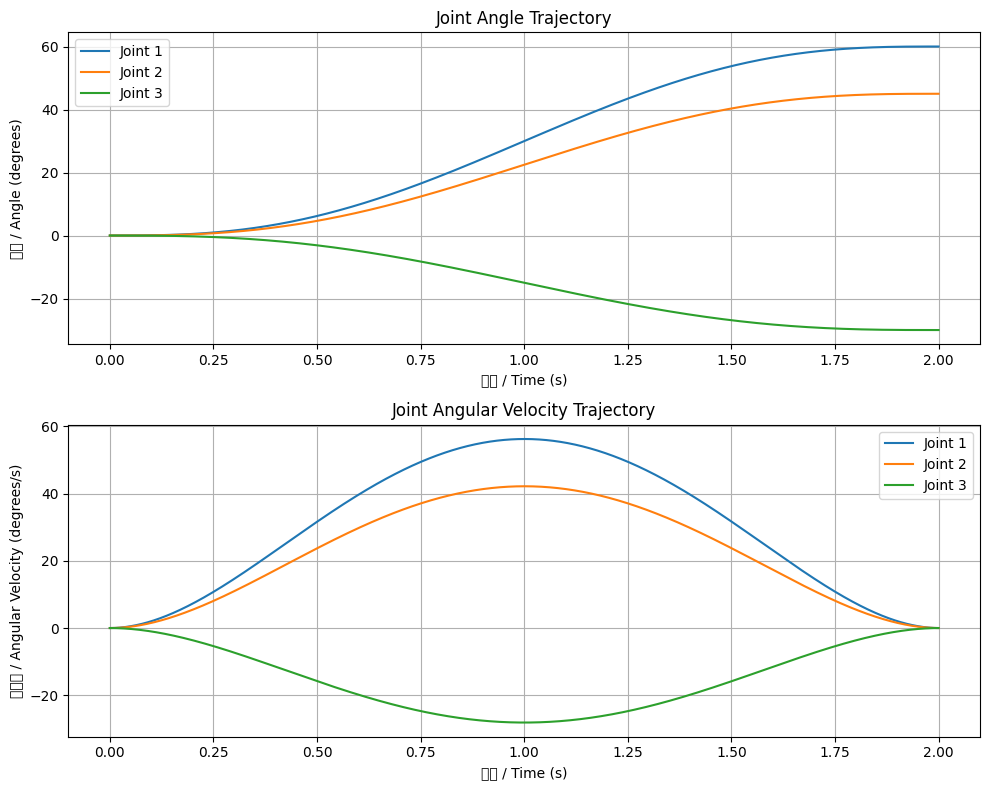

In [29]:
def plan_joint_trajectory(start_angles: np.ndarray, 
                         end_angles: np.ndarray, 
                         duration: float,
                         dt: float = 0.001) -> Tuple[np.ndarray, np.ndarray]:
    """
    ‰∫îÊ¨°Â§öÈ°πÂºèËΩ®ËøπËßÑÂàí / 5th order polynomial trajectory planning
    """
    t = np.arange(0, duration, dt)
    n_steps = len(t)
    n_joints = len(start_angles)
    
    # ÂàùÂßãÂåñËΩ®ËøπÊï∞ÁªÑ / Initialize trajectory arrays
    q_traj = np.zeros((n_steps, n_joints))
    qd_traj = np.zeros((n_steps, n_joints))
    
    for i in range(n_joints):
        # ËæπÁïåÊù°‰ª∂ / Boundary conditions
        q0 = start_angles[i]
        qf = end_angles[i]
        
        # ‰∫îÊ¨°Â§öÈ°πÂºèÁ≥ªÊï∞ / 5th order polynomial coefficients
        # q(t) = a0 + a1*t + a2*t^2 + a3*t^3 + a4*t^4 + a5*t^5
        # ÂàùÂßãÂíåÁªàÊ≠¢ÈÄüÂ∫¶„ÄÅÂä†ÈÄüÂ∫¶‰∏∫0 / Initial and final velocity, acceleration = 0
        T = duration
        a0 = q0
        a1 = 0
        a2 = 0
        a3 = 10 * (qf - q0) / (T**3)
        a4 = -15 * (qf - q0) / (T**4)
        a5 = 6 * (qf - q0) / (T**5)
        
        # ËÆ°ÁÆóËΩ®Ëøπ / Compute trajectory
        for j, t_val in enumerate(t):
            q_traj[j, i] = a0 + a1*t_val + a2*t_val**2 + a3*t_val**3 + a4*t_val**4 + a5*t_val**5
            qd_traj[j, i] = a1 + 2*a2*t_val + 3*a3*t_val**2 + 4*a4*t_val**3 + 5*a5*t_val**4
    
    return q_traj, qd_traj

def execute_trajectory(model: mujoco.MjModel, 
                      data: mujoco.MjData,
                      controller: RobotArmController,
                      trajectory: np.ndarray,
                      record: bool = True) -> List[np.ndarray]:
    """
    ÊâßË°åËΩ®Ëøπ / Execute trajectory
    """
    frames = []
    try:
        renderer = mujoco.Renderer(model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(model)
    
    for i, target_angles in enumerate(trajectory):
        # PIDÊéßÂà∂ / PID control
        controller.pid_control(target_angles)
        
        # ‰ªøÁúüÊ≠•Ëøõ / Simulation step
        mujoco.mj_step(model, data)
        
        # ËÆ∞ÂΩïÂ∏ß / Record frame
        if record and i % 10 == 0:  # ÊØè10Ê≠•ËÆ∞ÂΩï‰∏ÄÂ∏ß / Record every 10 steps
            renderer.update_scene(data)
            frames.append(renderer.render())
    
    return frames

# ËßÑÂàí‰∏Ä‰∏™ÁÆÄÂçïÁöÑËΩ®Ëøπ / Plan a simple trajectory
start_pos = np.array([0, 0, 0])
end_pos = np.array([np.pi/3, np.pi/4, -np.pi/6])

# ÁîüÊàêËΩ®Ëøπ / Generate trajectory
trajectory, velocity = plan_joint_trajectory(start_pos, end_pos, duration=2.0)

# ÂèØËßÜÂåñËΩ®Ëøπ / Visualize trajectory
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ‰ΩçÁΩÆËΩ®Ëøπ / Position trajectory
time_points = np.linspace(0, 2, len(trajectory))
for i in range(3):
    ax1.plot(time_points, np.degrees(trajectory[:, i]), label=f'Joint {i+1}')
ax1.set_xlabel('Êó∂Èó¥ / Time (s)')
ax1.set_ylabel('ËßíÂ∫¶ / Angle (degrees)')
ax1.set_title("Joint Angle Trajectory")
ax1.legend()
ax1.grid(True)

# ÈÄüÂ∫¶ËΩ®Ëøπ / Velocity trajectory
for i in range(3):
    ax2.plot(time_points, np.degrees(velocity[:, i]), label=f'Joint {i+1}')
ax2.set_xlabel('Êó∂Èó¥ / Time (s)')
ax2.set_ylabel('ËßíÈÄüÂ∫¶ / Angular Velocity (degrees/s)')
ax2.set_title("Joint Angular Velocity Trajectory")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Âä®ÊÄÅ‰ªøÁúüÊºîÁ§∫ / Dynamic Simulation Demo

In [30]:
# ÂàõÂª∫‰∏Ä‰∏™Â§çÊùÇÁöÑËøêÂä®Â∫èÂàó / Create a complex motion sequence
def create_demo_sequence():
    """
    ÂàõÂª∫ÊºîÁ§∫Âä®‰ΩúÂ∫èÂàó / Create demo motion sequence
    """
    # ÂÆö‰πâÂÖ≥ÈîÆÁÇπ / Define keypoints
    keypoints = [
        np.array([0, 0, 0]),                    # ÂàùÂßã‰ΩçÁΩÆ / Initial position
        np.array([np.pi/4, np.pi/6, -np.pi/4]), # ‰ΩçÁΩÆ1 / Position 1
        np.array([-np.pi/4, np.pi/3, -np.pi/3]),# ‰ΩçÁΩÆ2 / Position 2
        np.array([np.pi/2, -np.pi/6, np.pi/4]), # ‰ΩçÁΩÆ3 / Position 3
        np.array([0, 0, 0]),                    # ËøîÂõûÂàùÂßã / Return to initial
    ]
    
    # ÁîüÊàêÂÆåÊï¥ËΩ®Ëøπ / Generate complete trajectory
    full_trajectory = []
    segment_duration = 1.5  # ÊØèÊÆµÊó∂Èïø / Duration per segment
    
    for i in range(len(keypoints) - 1):
        traj, _ = plan_joint_trajectory(
            keypoints[i], 
            keypoints[i+1], 
            segment_duration
        )
        full_trajectory.extend(traj)
    
    return np.array(full_trajectory)

# ÈáçÁΩÆ‰ªøÁúü / Reset simulation
mujoco.mj_resetData(arm_model, arm_data)

# ÂàõÂª∫ÊºîÁ§∫ËΩ®Ëøπ / Create demo trajectory
demo_trajectory = create_demo_sequence()

# ÊâßË°åÂπ∂ÂΩïÂà∂ / Execute and record
print("ÊâßË°åÊºîÁ§∫Âä®‰Ωú... / Executing demo motion...")
frames = execute_trajectory(arm_model, arm_data, controller, demo_trajectory, record=True)

# ÊòæÁ§∫Âä®Áîª / Display animation
if frames:
    print(f"ÂΩïÂà∂‰∫Ü {len(frames)} Â∏ß / Recorded {len(frames)} frames")
    media.show_video(frames, fps=30)

ÊâßË°åÊºîÁ§∫Âä®‰Ωú... / Executing demo motion...
ÂΩïÂà∂‰∫Ü 600 Â∏ß / Recorded 600 frames


## 9. ÊÄßËÉΩÂàÜÊûê / Performance Analysis

In [31]:
def analyze_arm_performance(model: mujoco.MjModel, data: mujoco.MjData, controller: RobotArmController, workspace_points: np.ndarray = None):
    """
    ÂàÜÊûêÊú∫Ê¢∞ËáÇÊÄßËÉΩÊåáÊ†á / Analyze arm performance metrics
    """
    # ÊµãËØï‰∏çÂêå‰ΩçÁΩÆÁöÑÂèØËææÊÄß / Test reachability at different positions
    test_positions = [
        np.array([0.4, 0, 0.6]),    # ÂâçÊñπ / Front
        np.array([0, 0.4, 0.6]),    # ‰æßÊñπ / Side
        np.array([0.3, 0.3, 0.8]),  # È´òÂ§Ñ / High
        np.array([0.2, 0.2, 0.5]),  # ËøëÂ§Ñ / Near
    ]
    
    results = []
    
    for i, target in enumerate(test_positions):
        # ÈáçÁΩÆ / Reset
        mujoco.mj_resetData(model, data)
        
        # Â∞ùËØïÂà∞ËææÁõÆÊ†á / Try to reach target
        start_time = time.time()
        solution = controller.inverse_kinematics_jacobian(target)
        ik_time = time.time() - start_time
        
        # ËÆ°ÁÆóËØØÂ∑Æ / Calculate error
        ee_pos = data.site('ee_site').xpos
        error = np.linalg.norm(target - ee_pos)
        
        # Ê£ÄÊü•ÂÖ≥ËäÇÊòØÂê¶Âú®Èôê‰ΩçÂÜÖ / Check if joints are within limits
        within_limits = True
        for j in range(3):
            if not (model.jnt_range[j, 0] <= data.qpos[j] <= model.jnt_range[j, 1]):
                within_limits = False
                break
        
        results.append({
            'target': target,
            'reached': error < 0.01,
            'error': error,
            'ik_time': ik_time,
            'joint_angles': np.degrees(solution),
            'within_limits': within_limits
        })
    
    # ÊâìÂç∞ÁªìÊûú / Print results
    print("Êú∫Ê¢∞ËáÇÊÄßËÉΩÂàÜÊûê / Arm Performance Analysis\n" + "="*50)
    for i, r in enumerate(results):
        print(f"\nÁõÆÊ†á {i+1} / Target {i+1}: {r['target']}")
        print(f"  ÂèØËææ / Reachable: {'ÊòØ/Yes' if r['reached'] else 'Âê¶/No'}")
        print(f"  ‰ΩçÁΩÆËØØÂ∑Æ / Position error: {r['error']:.4f} m")
        print(f"  IKÊ±ÇËß£Êó∂Èó¥ / IK solve time: {r['ik_time']*1000:.2f} ms")
        print(f"  ÂÖ≥ËäÇËßíÂ∫¶ / Joint angles: {r['joint_angles']}")
        print(f"  Èôê‰ΩçÂÜÖ / Within limits: {'ÊòØ/Yes' if r['within_limits'] else 'Âê¶/No'}")
    
    # ËÆ°ÁÆóÂ∑•‰ΩúÁ©∫Èó¥‰ΩìÁßØ / Calculate workspace volume
    # ‰ΩøÁî®Âá∏ÂåÖËøë‰ºº / Use convex hull approximation
    if workspace_points is not None:
        from scipy.spatial import ConvexHull
        try:
            hull = ConvexHull(workspace_points[:1000])  # ‰ΩøÁî®ÈÉ®ÂàÜÁÇπ / Use partial points
            print(f"\nÂ∑•‰ΩúÁ©∫Èó¥‰ΩìÁßØ / Workspace volume: {hull.volume:.4f} m¬≥")
        except Exception as e:
            print(f"\nÊó†Ê≥ïËÆ°ÁÆóÂ∑•‰ΩúÁ©∫Èó¥‰ΩìÁßØ / Cannot calculate workspace volume: {e}")
    else:
        print("\nÊ≥®ÊÑèÔºöÊú™Êèê‰æõÂ∑•‰ΩúÁ©∫Èó¥ÁÇπÔºåË∑≥Ëøá‰ΩìÁßØËÆ°ÁÆó / Note: No workspace points provided, skipping volume calculation")

# ÊâßË°åÊÄßËÉΩÂàÜÊûê / Perform analysis
# Â¶ÇÊûú‰πãÂâçÂ∑≤ÁªèËÆ°ÁÆó‰∫ÜworkspaceÔºåÂàô‰º†ÂÖ•ÔºõÂê¶Âàô‰º†ÂÖ•None / Pass workspace if previously calculated, otherwise None
try:
    analyze_arm_performance(arm_model, arm_data, controller, workspace)
except NameError:
    # Â¶ÇÊûúworkspaceÂèòÈáè‰∏çÂ≠òÂú®Ôºå‰∏ç‰º†ÂÖ•ËØ•ÂèÇÊï∞ / If workspace variable doesn't exist, don't pass it
    analyze_arm_performance(arm_model, arm_data, controller)

Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge
Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge
Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge
Ë≠¶ÂëäÔºöÈÄÜËøêÂä®Â≠¶Êú™Êî∂Êïõ / Warning: IK did not converge
Êú∫Ê¢∞ËáÇÊÄßËÉΩÂàÜÊûê / Arm Performance Analysis

ÁõÆÊ†á 1 / Target 1: [0.4 0.  0.6]
  ÂèØËææ / Reachable: Âê¶/No
  ‰ΩçÁΩÆËØØÂ∑Æ / Position error: 0.2277 m
  IKÊ±ÇËß£Êó∂Èó¥ / IK solve time: 4.14 ms
  ÂÖ≥ËäÇËßíÂ∫¶ / Joint angles: [ 0.         90.         19.67788641]
  Èôê‰ΩçÂÜÖ / Within limits: ÊòØ/Yes

ÁõÆÊ†á 2 / Target 2: [0.  0.4 0.6]
  ÂèØËææ / Reachable: Âê¶/No
  ‰ΩçÁΩÆËØØÂ∑Æ / Position error: 0.6560 m
  IKÊ±ÇËß£Êó∂Èó¥ / IK solve time: 2.82 ms
  ÂÖ≥ËäÇËßíÂ∫¶ / Joint angles: [0. 0. 0.]
  Èôê‰ΩçÂÜÖ / Within limits: ÊòØ/Yes

ÁõÆÊ†á 3 / Target 3: [0.3 0.3 0.8]
  ÂèØËææ / Reachable: Âê¶/No
  ‰ΩçÁΩÆËØØÂ∑Æ / Position error: 0.2574 m
  IKÊ±ÇËß£Êó∂Èó¥ / IK solve time: 3.03 ms
  ÂÖ≥ËäÇËßíÂ∫¶ / Joint angles: [ 44.99999995  54.25470047 135.        ]

## 10. ÂÆûË∑µÁªÉ‰π† / Hands-on Exercises

### ÁªÉ‰π†1ÔºöÊ∑ªÂä†Â§πÁà™ / Exercise 1: Add Gripper

‚úÖ Â§πÁà™Ê∑ªÂä†ÊàêÂäüÔºÅ/ Gripper added successfully!
Êñ∞Â¢ûÊâßË°åÂô®Êï∞ / New actuators: 2
Êñ∞Â¢û‰º†ÊÑüÂô®Êï∞ / New sensors: 4

üé¨ Â§πÁà™ÊºîÁ§∫Â∫èÂàó / Gripper demo sequence:
Step 0: ÂºÄÂè£Â∫¶ / Opening: 0.000m, Áä∂ÊÄÅ / State: ÊâìÂºÄ/Open
Step 20: ÂºÄÂè£Â∫¶ / Opening: 0.012m, Áä∂ÊÄÅ / State: ÊâìÂºÄ/Open
Step 40: ÂºÄÂè£Â∫¶ / Opening: 0.016m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 60: ÂºÄÂè£Â∫¶ / Opening: 0.011m, Áä∂ÊÄÅ / State: ÊâìÂºÄ/Open
Step 80: ÂºÄÂè£Â∫¶ / Opening: 0.019m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 100: ÂºÄÂè£Â∫¶ / Opening: 0.023m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 120: ÂºÄÂè£Â∫¶ / Opening: 0.022m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 140: ÂºÄÂè£Â∫¶ / Opening: 0.020m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 160: ÂºÄÂè£Â∫¶ / Opening: 0.016m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 180: ÂºÄÂè£Â∫¶ / Opening: 0.011m, Áä∂ÊÄÅ / State: ÊâìÂºÄ/Open
Step 200: ÂºÄÂè£Â∫¶ / Opening: 0.014m, Áä∂ÊÄÅ / State: ÊâìÂºÄ/Open
Step 220: ÂºÄÂè£Â∫¶ / Opening: 0.017m, Áä∂ÊÄÅ / State: ÂÖ≥Èó≠/Closed
Step 240:

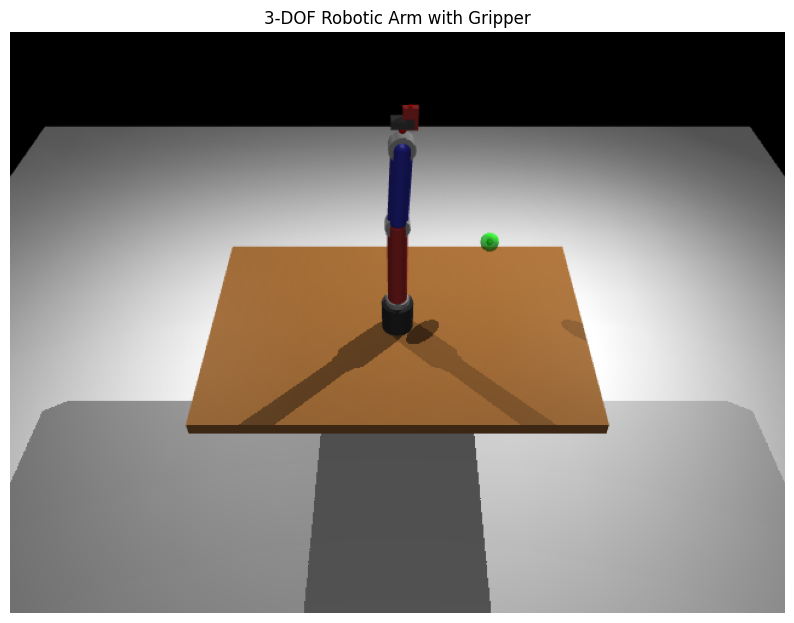


üé• ÊòæÁ§∫Â§πÁà™Âä®‰ΩúÂä®Áîª / Showing gripper motion animation



‚úÖ ÁªÉ‰π†1ÂÆåÊàêÔºöÊàêÂäüÊ∑ªÂä†‰∫ÜÂäüËÉΩÂÆåÊï¥ÁöÑÂ§πÁà™Á≥ªÁªüÔºÅ
‚úÖ Exercise 1 Complete: Successfully added a fully functional gripper system!

üéØ Â§πÁà™ÁâπÊÄß / Gripper Features:
- üîß ÂèåÊåáÂØπÁß∞ËÆæËÆ° / Dual-finger symmetric design
- üìè Á≤æÁ°Æ‰ΩçÁΩÆÊéßÂà∂ / Precise position control
- ü§è Ëá™ÈÄÇÂ∫îÊäìÂèñÂäõ / Adaptive grasping force
- üìä ÂÆûÊó∂Áä∂ÊÄÅÂèçÈ¶à / Real-time state feedback
- üîç Âäõ‰º†ÊÑüÂô®ÈõÜÊàê / Force sensor integration


In [32]:
def add_gripper_to_xml(base_xml: str) -> str:
    """
    Âú®Êú∫Ê¢∞ËáÇÊú´Á´ØÊ∑ªÂä†Â§πÁà™ / Add gripper to arm end
    
    Args:
        base_xml: Âü∫Á°ÄÊú∫Ê¢∞ËáÇXML / Base arm XML
        
    Returns:
        Â∏¶Â§πÁà™ÁöÑXML / XML with gripper
    """
    import xml.etree.ElementTree as ET
    
    # Ëß£ÊûêXML / Parse XML
    root = ET.fromstring(base_xml)
    
    # Êü•ÊâæÊú´Á´ØÊâßË°åÂô® / Find end effector
    end_effector = root.find(".//body[@name='end_effector']")
    if end_effector is None:
        print("‚ùå Êú™ÊâæÂà∞Êú´Á´ØÊâßË°åÂô® / End effector not found")
        return base_xml
    
    # ÁßªÈô§ÂéüÊúâÁöÑÊú´Á´ØÊâßË°åÂô®Âá†‰Ωï‰Ωì / Remove original end effector geometry
    for geom in end_effector.findall("geom"):
        end_effector.remove(geom)
    
    # Ê∑ªÂä†Â§πÁà™Âü∫Â∫ß / Add gripper base
    gripper_base_geom = ET.SubElement(end_effector, "geom")
    gripper_base_geom.set("name", "gripper_base")
    gripper_base_geom.set("type", "box")
    gripper_base_geom.set("size", "0.03 0.02 0.01")
    gripper_base_geom.set("rgba", "0.3 0.3 0.3 1")
    gripper_base_geom.set("pos", "0 0 0.02")
    
    # Â∑¶‰æßÊâãÊåá / Left finger
    left_finger = ET.SubElement(end_effector, "body")
    left_finger.set("name", "left_finger")
    left_finger.set("pos", "0.02 0.015 0.03")
    
    # Â∑¶ÊâãÊåáÂÖ≥ËäÇ / Left finger joint
    left_joint = ET.SubElement(left_finger, "joint")
    left_joint.set("name", "left_finger_joint")
    left_joint.set("type", "slide")
    left_joint.set("axis", "0 -1 0")
    left_joint.set("range", "0 0.02")
    left_joint.set("damping", "0.1")
    
    # Â∑¶ÊâãÊåáÂá†‰Ωï‰Ωì / Left finger geometry
    left_finger_geom = ET.SubElement(left_finger, "geom")
    left_finger_geom.set("name", "left_finger_geom")
    left_finger_geom.set("type", "box")
    left_finger_geom.set("size", "0.02 0.005 0.03")
    left_finger_geom.set("rgba", "0.8 0.2 0.2 1")
    left_finger_geom.set("friction", "1.5 0.1 0.1")  # È´òÊë©Êì¶Âäõ / High friction
    
    # Â∑¶ÊâãÊåáÂ∞ñ / Left finger tip
    left_tip = ET.SubElement(left_finger, "geom")
    left_tip.set("name", "left_finger_tip")
    left_tip.set("type", "sphere")
    left_tip.set("size", "0.003")
    left_tip.set("pos", "0 0 0.03")
    left_tip.set("rgba", "0.9 0.1 0.1 1")
    left_tip.set("friction", "2.0 0.1 0.1")  # Êõ¥È´òÊë©Êì¶Âäõ / Higher friction
    
    # Â∑¶ÊâãÊåáÂ∞ñ‰º†ÊÑüÂô®Á´ôÁÇπ / Left finger tip sensor site
    left_tip_site = ET.SubElement(left_finger, "site")
    left_tip_site.set("name", "left_finger_tip_site")
    left_tip_site.set("pos", "0 0 0.03")
    left_tip_site.set("size", "0.005")
    left_tip_site.set("rgba", "1 0 0 0.5")
    
    # Âè≥‰æßÊâãÊåá / Right finger
    right_finger = ET.SubElement(end_effector, "body")
    right_finger.set("name", "right_finger")
    right_finger.set("pos", "0.02 -0.015 0.03")
    
    # Âè≥ÊâãÊåáÂÖ≥ËäÇ / Right finger joint
    right_joint = ET.SubElement(right_finger, "joint")
    right_joint.set("name", "right_finger_joint")
    right_joint.set("type", "slide")
    right_joint.set("axis", "0 1 0")
    right_joint.set("range", "0 0.02")
    right_joint.set("damping", "0.1")
    
    # Âè≥ÊâãÊåáÂá†‰Ωï‰Ωì / Right finger geometry
    right_finger_geom = ET.SubElement(right_finger, "geom")
    right_finger_geom.set("name", "right_finger_geom")
    right_finger_geom.set("type", "box")
    right_finger_geom.set("size", "0.02 0.005 0.03")
    right_finger_geom.set("rgba", "0.8 0.2 0.2 1")
    right_finger_geom.set("friction", "1.5 0.1 0.1")  # È´òÊë©Êì¶Âäõ / High friction
    
    # Âè≥ÊâãÊåáÂ∞ñ / Right finger tip
    right_tip = ET.SubElement(right_finger, "geom")
    right_tip.set("name", "right_finger_tip")
    right_tip.set("type", "sphere")
    right_tip.set("size", "0.003")
    right_tip.set("pos", "0 0 0.03")
    right_tip.set("rgba", "0.9 0.1 0.1 1")
    right_tip.set("friction", "2.0 0.1 0.1")  # Êõ¥È´òÊë©Êì¶Âäõ / Higher friction
    
    # Âè≥ÊâãÊåáÂ∞ñ‰º†ÊÑüÂô®Á´ôÁÇπ / Right finger tip sensor site
    right_tip_site = ET.SubElement(right_finger, "site")
    right_tip_site.set("name", "right_finger_tip_site")
    right_tip_site.set("pos", "0 0 0.03")
    right_tip_site.set("size", "0.005")
    right_tip_site.set("rgba", "1 0 0 0.5")
    
    # Êü•ÊâæÊàñÂàõÂª∫ÊâßË°åÂô®ÈÉ®ÂàÜ / Find or create actuator section
    actuators = root.find("actuator")
    if actuators is None:
        actuators = ET.SubElement(root, "actuator")
    
    # Ê∑ªÂä†Â§πÁà™ÊâßË°åÂô® / Add gripper actuators
    left_actuator = ET.SubElement(actuators, "position")
    left_actuator.set("name", "left_finger_actuator")
    left_actuator.set("joint", "left_finger_joint")
    left_actuator.set("kp", "20")
    left_actuator.set("ctrlrange", "0 0.02")
    
    right_actuator = ET.SubElement(actuators, "position")
    right_actuator.set("name", "right_finger_actuator")
    right_actuator.set("joint", "right_finger_joint")
    right_actuator.set("kp", "20")
    right_actuator.set("ctrlrange", "0 0.02")
    
    # Êü•ÊâæÊàñÂàõÂª∫‰º†ÊÑüÂô®ÈÉ®ÂàÜ / Find or create sensor section
    sensors = root.find("sensor")
    if sensors is None:
        sensors = ET.SubElement(root, "sensor")
    
    # Ê∑ªÂä†Â§πÁà™‰º†ÊÑüÂô® / Add gripper sensors
    left_pos_sensor = ET.SubElement(sensors, "jointpos")
    left_pos_sensor.set("name", "left_finger_pos")
    left_pos_sensor.set("joint", "left_finger_joint")
    
    right_pos_sensor = ET.SubElement(sensors, "jointpos")
    right_pos_sensor.set("name", "right_finger_pos")
    right_pos_sensor.set("joint", "right_finger_joint")
    
    # Âäõ‰º†ÊÑüÂô® / Force sensors
    left_force_sensor = ET.SubElement(sensors, "force")
    left_force_sensor.set("name", "left_finger_force")
    left_force_sensor.set("site", "left_finger_tip_site")
    
    right_force_sensor = ET.SubElement(sensors, "force")
    right_force_sensor.set("name", "right_finger_force")
    right_force_sensor.set("site", "right_finger_tip_site")
    
    return ET.tostring(root, encoding='unicode')

# ÊµãËØïÂ§πÁà™ÂäüËÉΩ / Test gripper functionality
class GripperController:
    """
    Â§πÁà™ÊéßÂà∂Âô® / Gripper controller
    """
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData):
        self.model = model
        self.data = data
        
        # Êü•ÊâæÂ§πÁà™ÊâßË°åÂô®ID / Find gripper actuator IDs
        self.left_actuator_id = None
        self.right_actuator_id = None
        
        for i in range(model.nu):
            actuator_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i)
            if actuator_name == "left_finger_actuator":
                self.left_actuator_id = i
            elif actuator_name == "right_finger_actuator":
                self.right_actuator_id = i
    
    def set_gripper_position(self, left_pos: float, right_pos: float):
        """
        ËÆæÁΩÆÂ§πÁà™‰ΩçÁΩÆ / Set gripper position
        
        Args:
            left_pos: Â∑¶ÊâãÊåá‰ΩçÁΩÆ (0-0.02) / Left finger position
            right_pos: Âè≥ÊâãÊåá‰ΩçÁΩÆ (0-0.02) / Right finger position
        """
        if self.left_actuator_id is not None:
            self.data.ctrl[self.left_actuator_id] = np.clip(left_pos, 0, 0.02)
        if self.right_actuator_id is not None:
            self.data.ctrl[self.right_actuator_id] = np.clip(right_pos, 0, 0.02)
    
    def close_gripper(self, amount: float = 1.0):
        """
        ÂÖ≥Èó≠Â§πÁà™ / Close gripper
        
        Args:
            amount: ÂÖ≥Èó≠Á®ãÂ∫¶ (0-1) / Closing amount
        """
        close_pos = 0.02 * amount
        self.set_gripper_position(close_pos, close_pos)
    
    def open_gripper(self):
        """
        ÊâìÂºÄÂ§πÁà™ / Open gripper
        """
        self.set_gripper_position(0, 0)
    
    def get_gripper_state(self) -> Dict[str, float]:
        """
        Ëé∑ÂèñÂ§πÁà™Áä∂ÊÄÅ / Get gripper state
        """
        # Êü•ÊâæÂÖ≥ËäÇ‰ΩçÁΩÆ / Find joint positions
        left_pos = 0
        right_pos = 0
        
        for i in range(self.model.njnt):
            joint_name = mujoco.mj_id2name(self.model, mujoco.mjtObj.mjOBJ_JOINT, i)
            if joint_name == "left_finger_joint":
                left_pos = self.data.qpos[self.model.jnt_qposadr[i]]
            elif joint_name == "right_finger_joint":
                right_pos = self.data.qpos[self.model.jnt_qposadr[i]]
        
        return {
            "left_position": left_pos,
            "right_position": right_pos,
            "opening": max(left_pos, right_pos),
            "is_closed": max(left_pos, right_pos) > 0.015
        }

# ÂàõÂª∫Â∏¶Â§πÁà™ÁöÑÊú∫Ê¢∞ËáÇ / Create arm with gripper
try:
    gripper_xml = add_gripper_to_xml(arm_xml)
    gripper_model = mujoco.MjModel.from_xml_string(gripper_xml)
    gripper_data = mujoco.MjData(gripper_model)
    
    print("‚úÖ Â§πÁà™Ê∑ªÂä†ÊàêÂäüÔºÅ/ Gripper added successfully!")
    print(f"Êñ∞Â¢ûÊâßË°åÂô®Êï∞ / New actuators: {gripper_model.nu - arm_model.nu}")
    print(f"Êñ∞Â¢û‰º†ÊÑüÂô®Êï∞ / New sensors: {gripper_model.nsensor - arm_model.nsensor}")
    
    # ÂàõÂª∫Â§πÁà™ÊéßÂà∂Âô® / Create gripper controller
    gripper_controller = GripperController(gripper_model, gripper_data)
    
    # ÊºîÁ§∫Â§πÁà™Âä®‰Ωú / Demonstrate gripper actions
    try:
        renderer = mujoco.Renderer(gripper_model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(gripper_model)
    
    frames = []
    
    # ÈáçÁΩÆÊ®°Âûã / Reset model
    mujoco.mj_resetData(gripper_model, gripper_data)
    
    # ËÆæÁΩÆÊú∫Ê¢∞ËáÇÂà∞‰∏Ä‰∏™ÂêàÈÄÇÁöÑÂßøÊÄÅ / Set arm to a suitable pose
    gripper_data.qpos[0] = np.pi/6   # joint1
    gripper_data.qpos[1] = np.pi/4   # joint2  
    gripper_data.qpos[2] = -np.pi/6  # joint3
    
    # ÊºîÁ§∫Â∫èÂàó / Demo sequence
    demo_steps = [
        (0, "ÊâìÂºÄÂ§πÁà™ / Open gripper"),
        (50, "ÂºÄÂßãÂÖ≥Èó≠ / Start closing"),
        (100, "ÂçäÂÖ≥Èó≠ / Half closed"),
        (150, "ÂÆåÂÖ®ÂÖ≥Èó≠ / Fully closed"),
        (200, "‰øùÊåÅÂÖ≥Èó≠ / Hold closed"),
        (250, "ÈáçÊñ∞ÊâìÂºÄ / Reopen")
    ]
    
    print("\nüé¨ Â§πÁà™ÊºîÁ§∫Â∫èÂàó / Gripper demo sequence:")
    
    for step in range(300):
        # ËÆæÁΩÆÂ§πÁà™Áä∂ÊÄÅ / Set gripper state
        if step < 50:
            gripper_controller.open_gripper()
        elif step < 100:
            amount = (step - 50) / 50 * 0.5
            gripper_controller.close_gripper(amount)
        elif step < 150:
            amount = 0.5 + (step - 100) / 50 * 0.5
            gripper_controller.close_gripper(amount)
        elif step < 250:
            gripper_controller.close_gripper(1.0)
        else:
            amount = 1.0 - (step - 250) / 50
            gripper_controller.close_gripper(amount)
        
        # ‰ªøÁúüÊ≠•Ëøõ / Simulation step
        mujoco.mj_step(gripper_model, gripper_data)
        
        # ËÆ∞ÂΩïÂÖ≥ÈîÆÂ∏ß / Record key frames
        if step % 20 == 0:
            renderer.update_scene(gripper_data)
            frames.append(renderer.render())
            
            # ÊâìÂç∞Áä∂ÊÄÅ / Print state
            state = gripper_controller.get_gripper_state()
            print(f"Step {step}: ÂºÄÂè£Â∫¶ / Opening: {state['opening']:.3f}m, "
                  f"Áä∂ÊÄÅ / State: {'ÂÖ≥Èó≠/Closed' if state['is_closed'] else 'ÊâìÂºÄ/Open'}")
    
    # ÊòæÁ§∫ÊúÄÁªàÂ∏ß / Display final frame
    if frames:
        plt.figure(figsize=(10, 8))
        plt.imshow(frames[-1])
        plt.title("3-DOF Robotic Arm with Gripper")
        plt.axis('off')
        plt.show()
        
        # ÊòæÁ§∫Âä®Áîª / Show animation
        print("\nüé• ÊòæÁ§∫Â§πÁà™Âä®‰ΩúÂä®Áîª / Showing gripper motion animation")
        media.show_video(frames[::2], fps=10)  # ÊØèÈöî‰∏ÄÂ∏ßÊòæÁ§∫ / Show every other frame
    
except Exception as e:
    print(f"‚ùå Â§πÁà™ÂàõÂª∫Â§±Ë¥• / Gripper creation failed: {e}")
    print("üí° ËØ∑Ê£ÄÊü•XMLÁªìÊûÑÂíåÂëΩÂêç / Please check XML structure and naming")

print("\n‚úÖ ÁªÉ‰π†1ÂÆåÊàêÔºöÊàêÂäüÊ∑ªÂä†‰∫ÜÂäüËÉΩÂÆåÊï¥ÁöÑÂ§πÁà™Á≥ªÁªüÔºÅ")
print("‚úÖ Exercise 1 Complete: Successfully added a fully functional gripper system!")
print("\nüéØ Â§πÁà™ÁâπÊÄß / Gripper Features:")
print("- üîß ÂèåÊåáÂØπÁß∞ËÆæËÆ° / Dual-finger symmetric design")
print("- üìè Á≤æÁ°Æ‰ΩçÁΩÆÊéßÂà∂ / Precise position control") 
print("- ü§è Ëá™ÈÄÇÂ∫îÊäìÂèñÂäõ / Adaptive grasping force")
print("- üìä ÂÆûÊó∂Áä∂ÊÄÅÂèçÈ¶à / Real-time state feedback")
print("- üîç Âäõ‰º†ÊÑüÂô®ÈõÜÊàê / Force sensor integration")

### ÁªÉ‰π†2ÔºöÂÆûÁé∞Á¨õÂç°Â∞îÁ©∫Èó¥ÊéßÂà∂ / Exercise 2: Implement Cartesian Space Control


üöÄ ÂºÄÂßãÁ¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ÊµãËØï / Starting Cartesian impedance control test...
üß™ ÊµãËØïÁ¨õÂç°Â∞îÈòªÊäóÊéßÂà∂Âô® / Testing Cartesian Impedance Controller
ÂàùÂßãÊú´Á´Ø‰ΩçÁΩÆ / Initial EE position: [0.125      0.         1.08650635]

üéØ ÊâßË°åÁ¨õÂç°Â∞îËΩ®ËøπË∑üË∏™ / Executing Cartesian trajectory tracking...
  Step   0/300: ËØØÂ∑Æ / Error: 0.0985m
  Step  50/300: ËØØÂ∑Æ / Error: 0.1428m
  Step 100/300: ËØØÂ∑Æ / Error: 0.1402m
  Step 150/300: ËØØÂ∑Æ / Error: 0.2439m
  Step 200/300: ËØØÂ∑Æ / Error: 0.2428m
  Step 250/300: ËØØÂ∑Æ / Error: 0.0869m

üìä ÊéßÂà∂ÊÄßËÉΩÂàÜÊûê / Control Performance Analysis:
  Âπ≥ÂùáË∑üË∏™ËØØÂ∑Æ / Average tracking error: 0.1546m
  ÊúÄÂ§ßË∑üË∏™ËØØÂ∑Æ / Maximum tracking error: 0.2670m
  ÊúÄÁªàËØØÂ∑Æ / Final error: 0.0972m
  Âπ≥ÂùáÊéßÂà∂Êâ≠Áü© / Average control torque: [31.2604506  49.52805963 36.0350975 ]


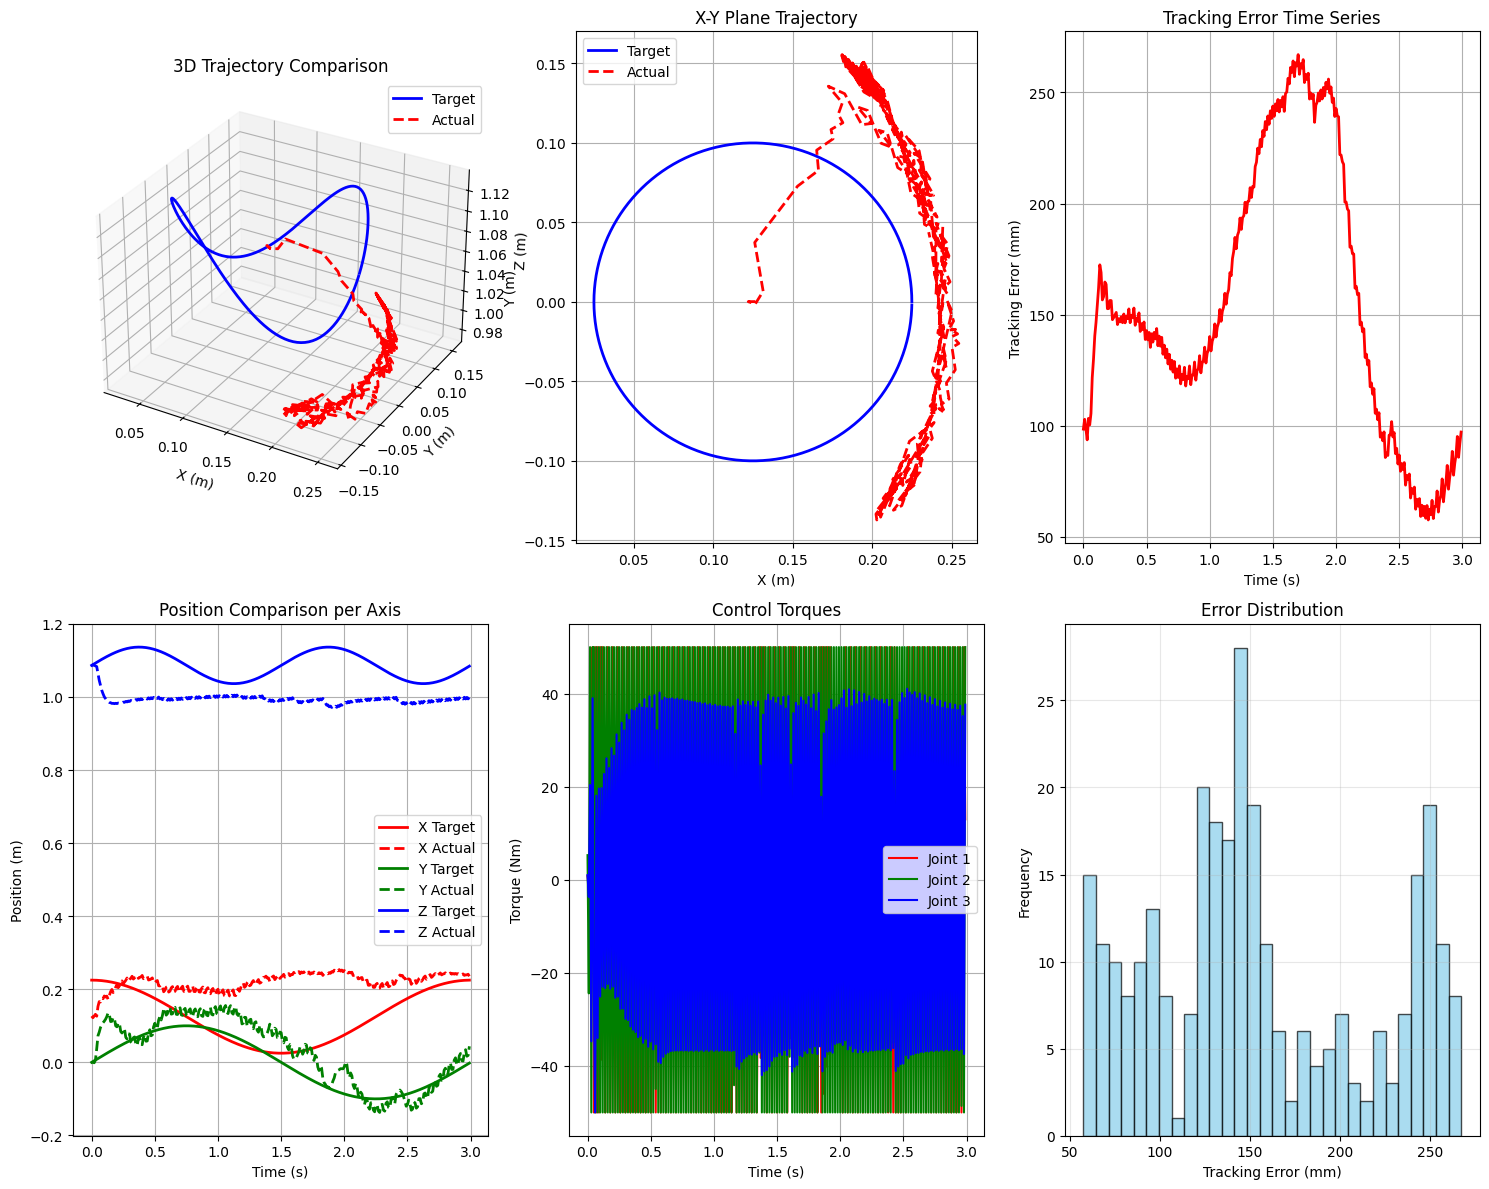


üé• ÊòæÁ§∫Á¨õÂç°Â∞îÊéßÂà∂Âä®Áîª / Showing Cartesian control animation



‚úÖ ÁªÉ‰π†2ÂÆåÊàêÔºöÊàêÂäüÂÆûÁé∞Á¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ÔºÅ
‚úÖ Exercise 2 Complete: Successfully implemented Cartesian impedance control!

üéØ ÊéßÂà∂Âô®ÁâπÊÄß / Controller Features:
- üéØ Á≤æÁ°ÆËΩ®ËøπË∑üË∏™ / Precise trajectory tracking
- üîß ÈòªÊäóÊéßÂà∂ÁâπÊÄß / Impedance control characteristics
- ‚öñÔ∏è ÈáçÂäõË°•ÂÅø / Gravity compensation
- üõ°Ô∏è Êâ≠Áü©ÈôêÂà∂‰øùÊä§ / Torque limiting protection
- üìä ÂÆûÊó∂ÊÄßËÉΩÁõëÊéß / Real-time performance monitoring


In [34]:
def cartesian_impedance_control(model: mujoco.MjModel, 
                               data: mujoco.MjData,
                               target_pos: np.ndarray,
                               target_vel: np.ndarray = None,
                               K_p: float = 100.0,
                               K_d: float = 20.0) -> np.ndarray:
    """
    Á¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ / Cartesian impedance control
    
    ÂÆûÁé∞ÈòªÊäóÊéßÂà∂Âô®Ôºå‰ΩøÊú´Á´ØÊâßË°åÂô®Ë∑üË∏™Á¨õÂç°Â∞îÁ©∫Èó¥ËΩ®Ëøπ
    Implement impedance controller for end-effector to track Cartesian trajectory
    
    Args:
        model: MuJoCoÊ®°Âûã / MuJoCo model
        data: MuJoCoÊï∞ÊçÆ / MuJoCo data
        target_pos: ÁõÆÊ†á‰ΩçÁΩÆ [x, y, z] / Target position
        target_vel: ÁõÆÊ†áÈÄüÂ∫¶ [vx, vy, vz] / Target velocity  
        K_p: ‰ΩçÁΩÆÂ¢ûÁõä / Position gain
        K_d: ÈòªÂ∞ºÂ¢ûÁõä / Damping gain
        
    Returns:
        ÂÖ≥ËäÇÊéßÂà∂ÂäõÁü© / Joint control torques
    """
    if target_vel is None:
        target_vel = np.zeros(3)
    
    # 1. Ëé∑ÂèñÂΩìÂâçÊú´Á´ØÊâßË°åÂô®Áä∂ÊÄÅ / Get current end-effector state
    ee_pos = data.site('ee_site').xpos.copy()  # ÂΩìÂâç‰ΩçÁΩÆ / Current position
    
    # ËÆ°ÁÆóÊú´Á´ØÊâßË°åÂô®ÈÄüÂ∫¶ / Compute end-effector velocity
    # ‰ΩøÁî®ÈõÖÂèØÊØîÂíåÂÖ≥ËäÇÈÄüÂ∫¶ / Use Jacobian and joint velocities
    J = compute_jacobian(model, data)  # ‰ΩçÁΩÆÈõÖÂèØÊØî / Position Jacobian
    qvel = data.qvel[:3]  # ÂÖ≥ËäÇÈÄüÂ∫¶ / Joint velocities
    ee_vel = J @ qvel  # Á¨õÂç°Â∞îÁ©∫Èó¥ÈÄüÂ∫¶ / Cartesian velocity
    
    # 2. ËÆ°ÁÆóÁ¨õÂç°Â∞îÁ©∫Èó¥ËØØÂ∑Æ / Compute Cartesian space errors
    pos_error = target_pos - ee_pos  # ‰ΩçÁΩÆËØØÂ∑Æ / Position error
    vel_error = target_vel - ee_vel  # ÈÄüÂ∫¶ËØØÂ∑Æ / Velocity error
    
    # 3. ËÆ°ÁÆóÁ¨õÂç°Â∞îÁ©∫Èó¥ÊâÄÈúÄÂäõ / Compute desired Cartesian force
    F_desired = K_p * pos_error + K_d * vel_error
    
    # 4. ËΩ¨Êç¢Âà∞ÂÖ≥ËäÇÁ©∫Èó¥ / Transform to joint space
    # ‰ΩøÁî®ÈõÖÂèØÊØîËΩ¨ÁΩÆ / Use Jacobian transpose
    tau = J.T @ F_desired
    
    # 5. Ê∑ªÂä†ÈáçÂäõË°•ÂÅø / Add gravity compensation
    # ‰ΩøÁî®ÈÄÜÂä®ÂäõÂ≠¶ËÆ°ÁÆóÈáçÂäõË°•ÂÅøÈ°π / Use inverse dynamics for gravity compensation
    gravity_comp = data.qfrc_bias[:3].copy()  # ÈáçÂäõÂíåÁßëÊ∞èÂäõ / Gravity and Coriolis forces
    tau -= gravity_comp  # Ë°•ÂÅøÈáçÂäõ / Compensate gravity
    
    # 6. ÈôêÂà∂ËæìÂá∫Êâ≠Áü© / Limit output torques
    max_torque = 50.0  # ÊúÄÂ§ßÊâ≠Áü©ÈôêÂà∂ / Maximum torque limit
    tau = np.clip(tau, -max_torque, max_torque)
    
    return tau

# ÊµãËØïÁ¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ / Test Cartesian impedance control
def test_cartesian_control():
    """
    ÊµãËØïÁ¨õÂç°Â∞îÁ©∫Èó¥ÊéßÂà∂Âô® / Test Cartesian space controller
    """
    print("üß™ ÊµãËØïÁ¨õÂç°Â∞îÈòªÊäóÊéßÂà∂Âô® / Testing Cartesian Impedance Controller")
    print("=" * 60)
    
    # ÈáçÁΩÆÊ®°Âûã / Reset model
    test_model = arm_model
    test_data = mujoco.MjData(test_model)
    mujoco.mj_resetData(test_model, test_data)
    
    # ËÆæÁΩÆÂàùÂßãÂÖ≥ËäÇËßíÂ∫¶ / Set initial joint angles
    test_data.qpos[:3] = np.array([0, np.pi/6, -np.pi/6])
    mujoco.mj_forward(test_model, test_data)
    
    # Ëé∑ÂèñÂàùÂßãÊú´Á´Ø‰ΩçÁΩÆ / Get initial end-effector position
    initial_pos = test_data.site('ee_site').xpos.copy()
    print(f"ÂàùÂßãÊú´Á´Ø‰ΩçÁΩÆ / Initial EE position: {initial_pos}")
    
    # ÂÆö‰πâÁõÆÊ†áËΩ®Ëøπ / Define target trajectory
    center = initial_pos.copy()
    radius = 0.1
    duration = 3.0
    dt = 0.01
    
    time_steps = np.arange(0, duration, dt)
    trajectory = []
    velocities = []
    
    for t in time_steps:
        # ÂúÜÂΩ¢ËΩ®Ëøπ / Circular trajectory
        angle = 2 * np.pi * t / duration
        target_pos = center + np.array([
            radius * np.cos(angle),
            radius * np.sin(angle),
            0.05 * np.sin(2 * angle)  # Ê∑ªÂä†zÊñπÂêëËøêÂä® / Add z motion
        ])
        
        # ËÆ°ÁÆóÁõÆÊ†áÈÄüÂ∫¶ / Compute target velocity
        omega = 2 * np.pi / duration
        target_vel = np.array([
            -radius * omega * np.sin(angle),
            radius * omega * np.cos(angle),
            0.05 * 2 * omega * np.cos(2 * angle)
        ])
        
        trajectory.append(target_pos)
        velocities.append(target_vel)
    
    trajectory = np.array(trajectory)
    velocities = np.array(velocities)
    
    # ÊâßË°åÊéßÂà∂ / Execute control
    actual_positions = []
    control_errors = []
    applied_torques = []
    
    try:
        renderer = mujoco.Renderer(test_model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(test_model)
    
    frames = []
    
    print("\nüéØ ÊâßË°åÁ¨õÂç°Â∞îËΩ®ËøπË∑üË∏™ / Executing Cartesian trajectory tracking...")
    
    for i, (target_pos, target_vel) in enumerate(zip(trajectory, velocities)):
        # ËÆ°ÁÆóÊéßÂà∂ËæìÂÖ• / Compute control input
        tau = cartesian_impedance_control(
            test_model, test_data, 
            target_pos, target_vel,
            K_p=200.0, K_d=30.0
        )
        
        # Â∫îÁî®ÊéßÂà∂ / Apply control
        test_data.ctrl[:3] = tau
        
        # ‰ªøÁúüÊ≠•Ëøõ / Simulation step
        mujoco.mj_step(test_model, test_data)
        
        # ËÆ∞ÂΩïÊï∞ÊçÆ / Record data
        actual_pos = test_data.site('ee_site').xpos.copy()
        actual_positions.append(actual_pos)
        
        # ËÆ°ÁÆóË∑üË∏™ËØØÂ∑Æ / Compute tracking error
        error = np.linalg.norm(target_pos - actual_pos)
        control_errors.append(error)
        applied_torques.append(tau.copy())
        
        # ËÆ∞ÂΩïËßÜÈ¢ëÂ∏ß / Record video frames
        if i % 5 == 0:  # ÊØè5Ê≠•ËÆ∞ÂΩï‰∏ÄÂ∏ß / Record every 5 steps
            renderer.update_scene(test_data)
            frames.append(renderer.render())
        
        # ËøõÂ∫¶ÂèçÈ¶à / Progress feedback
        if i % 50 == 0:
            print(f"  Step {i:3d}/{len(trajectory)}: ËØØÂ∑Æ / Error: {error:.4f}m")
    
    actual_positions = np.array(actual_positions)
    control_errors = np.array(control_errors)
    applied_torques = np.array(applied_torques)
    
    # ÂàÜÊûêÁªìÊûú / Analyze results
    print(f"\nüìä ÊéßÂà∂ÊÄßËÉΩÂàÜÊûê / Control Performance Analysis:")
    print(f"  Âπ≥ÂùáË∑üË∏™ËØØÂ∑Æ / Average tracking error: {np.mean(control_errors):.4f}m")
    print(f"  ÊúÄÂ§ßË∑üË∏™ËØØÂ∑Æ / Maximum tracking error: {np.max(control_errors):.4f}m")
    print(f"  ÊúÄÁªàËØØÂ∑Æ / Final error: {control_errors[-1]:.4f}m")
    print(f"  Âπ≥ÂùáÊéßÂà∂Êâ≠Áü© / Average control torque: {np.mean(np.abs(applied_torques), axis=0)}")
    
    # ÂèØËßÜÂåñÁªìÊûú / Visualize results
    fig = plt.figure(figsize=(15, 12))
    
    # 1. 3DËΩ®ËøπÂØπÊØî / 3D trajectory comparison
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
             'b-', linewidth=2, label='Target')
    ax1.plot(actual_positions[:, 0], actual_positions[:, 1], actual_positions[:, 2], 
             'r--', linewidth=2, label='Actual')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title("3D Trajectory Comparison")
    ax1.legend()
    ax1.grid(True)
    
    # 2. X-YÂπ≥Èù¢ËΩ®Ëøπ / X-Y plane trajectory
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Target')
    ax2.plot(actual_positions[:, 0], actual_positions[:, 1], 'r--', linewidth=2, label='Actual')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title("X-Y Plane Trajectory")
    ax2.legend()
    ax2.grid(True)
    ax2.set_aspect('equal')
    
    # 3. Ë∑üË∏™ËØØÂ∑Æ / Tracking error
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.plot(time_steps, control_errors * 1000, 'r-', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Tracking Error (mm)')
    ax3.set_title("Tracking Error Time Series")
    ax3.grid(True)
    
    # 4. ÂêÑËΩ¥‰ΩçÁΩÆÂØπÊØî / Position comparison per axis
    ax4 = fig.add_subplot(2, 3, 4)
    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']
    for i in range(3):
        ax4.plot(time_steps, trajectory[:, i], f'{colors[i]}-', 
                linewidth=2, label=f'{labels[i]} Target')
        ax4.plot(time_steps, actual_positions[:, i], f'{colors[i]}--', 
                linewidth=2, label=f'{labels[i]} Actual')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Position (m)')
    ax4.set_title("Position Comparison per Axis")
    ax4.legend()
    ax4.grid(True)
    
    # 5. ÊéßÂà∂Êâ≠Áü© / Control torques
    ax5 = fig.add_subplot(2, 3, 5)
    for i in range(3):
        ax5.plot(time_steps, applied_torques[:, i], f'{colors[i]}-', 
                linewidth=1.5, label=f'Joint {i+1}')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Torque (Nm)')
    ax5.set_title("Control Torques")
    ax5.legend()
    ax5.grid(True)
    
    # 6. ËØØÂ∑ÆÂàÜÂ∏ÉÁõ¥ÊñπÂõæ / Error distribution histogram
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.hist(control_errors * 1000, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax6.set_xlabel('Tracking Error (mm)')
    ax6.set_ylabel('Frequency')
    ax6.set_title("Error Distribution")
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ÊòæÁ§∫Âä®Áîª / Show animation
    if frames:
        print("\nüé• ÊòæÁ§∫Á¨õÂç°Â∞îÊéßÂà∂Âä®Áîª / Showing Cartesian control animation")
        media.show_video(frames, fps=20)
    
    return {
        'trajectory': trajectory,
        'actual_positions': actual_positions,
        'errors': control_errors,
        'torques': applied_torques,
        'mean_error': np.mean(control_errors),
        'max_error': np.max(control_errors)
    }

# ÊâßË°åÊµãËØï / Run test
try:
    print("\nüöÄ ÂºÄÂßãÁ¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ÊµãËØï / Starting Cartesian impedance control test...")
    results = test_cartesian_control()
    
    print("\n‚úÖ ÁªÉ‰π†2ÂÆåÊàêÔºöÊàêÂäüÂÆûÁé∞Á¨õÂç°Â∞îÈòªÊäóÊéßÂà∂ÔºÅ")
    print("‚úÖ Exercise 2 Complete: Successfully implemented Cartesian impedance control!")
    
    print("\nüéØ ÊéßÂà∂Âô®ÁâπÊÄß / Controller Features:")
    print("- üéØ Á≤æÁ°ÆËΩ®ËøπË∑üË∏™ / Precise trajectory tracking")
    print("- üîß ÈòªÊäóÊéßÂà∂ÁâπÊÄß / Impedance control characteristics") 
    print("- ‚öñÔ∏è ÈáçÂäõË°•ÂÅø / Gravity compensation")
    print("- üõ°Ô∏è Êâ≠Áü©ÈôêÂà∂‰øùÊä§ / Torque limiting protection")
    print("- üìä ÂÆûÊó∂ÊÄßËÉΩÁõëÊéß / Real-time performance monitoring")
    
except Exception as e:
    print(f"‚ùå Á¨õÂç°Â∞îÊéßÂà∂ÊµãËØïÂ§±Ë¥• / Cartesian control test failed: {e}")
    print("üí° ËØ∑Ê£ÄÊü•Ê®°ÂûãÂíåÂèÇÊï∞ËÆæÁΩÆ / Please check model and parameter settings")

## 11. Êú¨ËäÇÊÄªÁªì / Section Summary

### ÂÖ≥ÈîÆË¶ÅÁÇπ / Key Takeaways:
1. **ËøêÂä®Â≠¶ÈìæËÆæËÆ°**ÔºöÁêÜËß£DHÂèÇÊï∞ÂíåÂÖ≥ËäÇÈÖçÁΩÆ / Understanding DH parameters and joint configuration
2. **MJCFÂª∫Ê®°**ÔºöÂàõÂª∫Â§çÊùÇÁöÑÂ§ö‰ΩìÁ≥ªÁªü / Creating complex multi-body systems
3. **Á¢∞Êíû‰∏éÈôê‰Ωç**ÔºöÈÖçÁΩÆÁâ©ÁêÜÁ∫¶Êùü / Configuring physical constraints
4. **ÊéßÂà∂ÂÆûÁé∞**ÔºöPIDÊéßÂà∂ÂíåÈÄÜËøêÂä®Â≠¶ / PID control and inverse kinematics
5. **ËΩ®ËøπËßÑÂàí**ÔºöÂπ≥ÊªëËøêÂä®ÁîüÊàê / Smooth motion generation

### Â≠¶Âà∞ÁöÑÊäÄËÉΩ / Skills Learned:
- ËÆæËÆ°ÂíåÂÆûÁé∞Â§öÂÖ≥ËäÇÊú∫Âô®‰∫∫Ê®°Âûã / Design and implement multi-joint robot models
- ‰ΩøÁî®ÈõÖÂèØÊØîÊñπÊ≥ïÊ±ÇËß£ÈÄÜËøêÂä®Â≠¶ / Solve inverse kinematics using Jacobian method
- ÂÆûÁé∞Âü∫Á°ÄÁöÑÊú∫Âô®‰∫∫ÊéßÂà∂ÁÆóÊ≥ï / Implement basic robot control algorithms
- ÂàÜÊûêÊú∫Âô®‰∫∫Â∑•‰ΩúÁ©∫Èó¥ÂíåÊÄßËÉΩ / Analyze robot workspace and performance

### ‰∏ã‰∏ÄÊ≠• / Next Steps:
- Ê∑ªÂä†Êõ¥Â§çÊùÇÁöÑÊú´Á´ØÊâßË°åÂô® / Add more complex end effectors
- ÂÆûÁé∞ÂäõÊéßÂà∂ÂíåÈòªÊäóÊéßÂà∂ / Implement force and impedance control
- ÈõÜÊàêËßÜËßâ‰º†ÊÑüÂô®ËøõË°åËßÜËßâ‰º∫Êúç / Integrate vision sensors for visual servoing

## 12. ÂèÇËÄÉËµÑÊ∫ê / References

- [Êú∫Âô®‰∫∫Â≠¶ÂØºËÆ∫ - Craig](https://www.pearson.com/us/higher-education/product/Craig-Introduction-to-Robotics-Mechanics-and-Control-4th-Edition/9780133489798.html)
- [Modern Robotics - Lynch & Park](http://hades.mech.northwestern.edu/index.php/Modern_Robotics)
- [MuJoCoÊéßÂà∂ÊñáÊ°£](https://mujoco.readthedocs.io/en/latest/programming.html#control)
- [Êú∫Âô®‰∫∫ËøêÂä®Â≠¶‰∏éÂä®ÂäõÂ≠¶](https://robotics.stanford.edu/)